In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/AVP-BDD/'
os.chdir(path)


In [68]:
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

def load_bids_events(layout,onsets, subject, task, run):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 1
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [1,4,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

def create_loc_events_file(sub):
    subID = 'sub-'+sub
    # Base directories
    base_input = "/Volumes/Seagate Desktop Drive/AVP-BDD/behavior"
    base_output = "/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives"

    input_dir = os.path.join(base_input, sub, "localizer")
    #outsubID = 'sub-'
    output_dir = os.path.join(base_output, subID, "ses-01", "func")
    
    # Find the .tsv file inside the localizer folder
    tsv_files = glob.glob(os.path.join(input_dir, "*.tsv"))
    
    if not tsv_files:
        print(f"No TSV file found for {sub}")

    # Assume there’s only one TSV per subject
    file_path = tsv_files[0]
    
    # Create output path (same filename but saved as .csv)
    output_path = os.path.join(output_dir, "localizer-events.csv")
    
    data = pd.read_csv(file_path, delimiter='\t')  # Adjust delimiter if necessary

    data["category"] = data["adult(1)/child(2)/body(3)/limb(4)/car(5)/instrument(6)/house(7)/corridor(8)/scrambled(9)"]

    # Define category mapping
    category_mapping = {
        1: "adult", 2: "child", 3: "body", 4: "limb", 5: "car",
        6: "instrument", 7: "house", 8: "corridor", 9: "scrambled"
    }

    data["category"] = data["category"].map(category_mapping)

    # Round onset and calculate end times rounded to the nearest second
    data["onset_rounded"] = np.round(data["onset"]).astype(int)
    data["end_time"] = data["onset"] + data["duration"]
    data["end_time_rounded"] = np.round(data["end_time"]).astype(int)

    # Extract unique blocks
    block_summary = data.groupby("block").agg({
        "onset_rounded": "first",
        "end_time_rounded": "last",
        "category": "first"
    }).reset_index()

    # Rename columns for clarity
    block_summary.rename(columns={
        "onset_rounded": "onset",
        "end_time_rounded": "block_end",
        "category": "trial_type"
    }, inplace=True)
    block_summary["duration"] = block_summary["block_end"]-block_summary["onset"]


    # # Save the processed data
    
    block_summary.to_csv(output_path, index=False)
    return block_summary


BIDS Layout: ...ktop Drive/AVP-BDD/derivatives | Subjects: 46 | Sessions: 46 | Runs: 138


In [58]:
subjects = layout.get_subjects()
subjects = subjects[1:20]

Whole-brain GLM for localizer task: 

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:160: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too

TypeError: Cannot concatenate empty objects

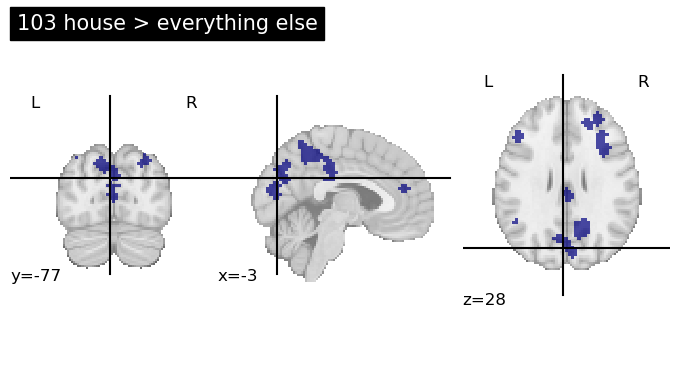

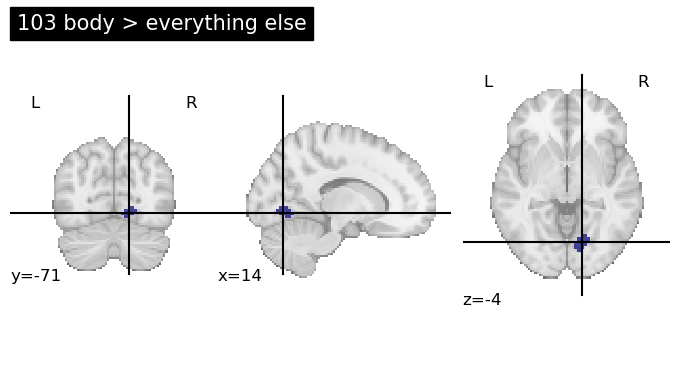

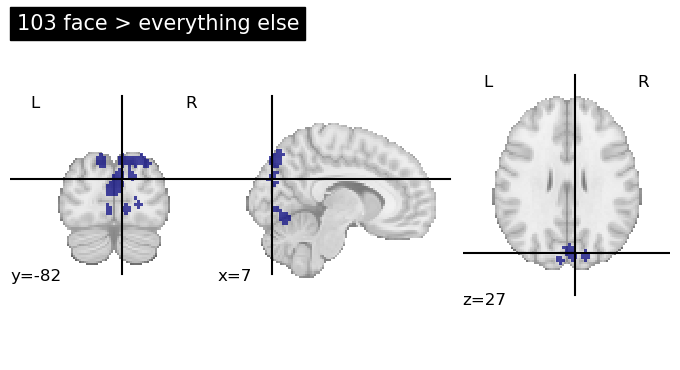

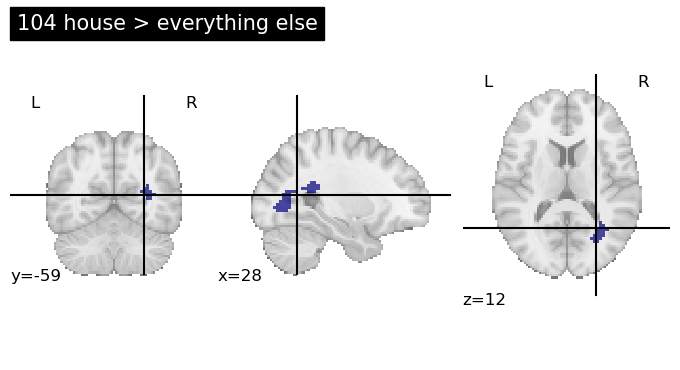

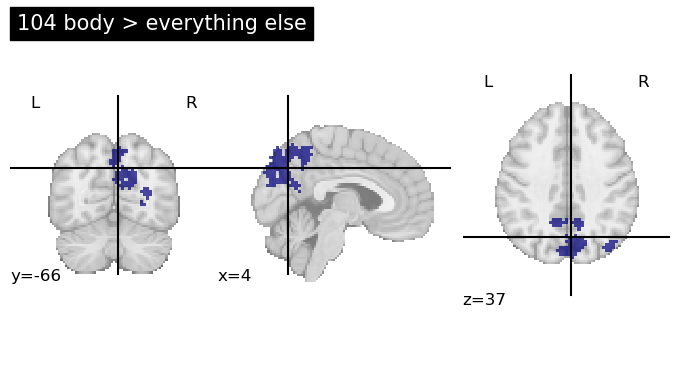

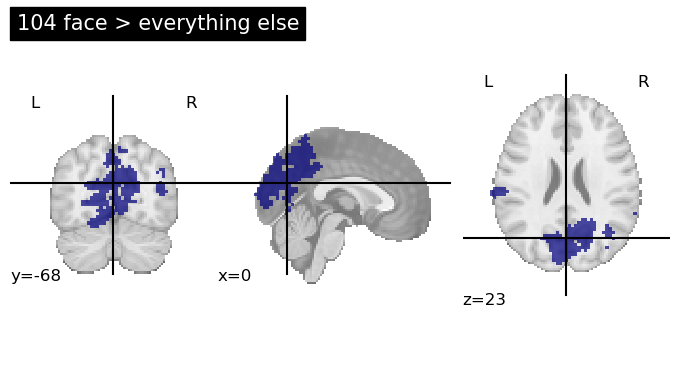

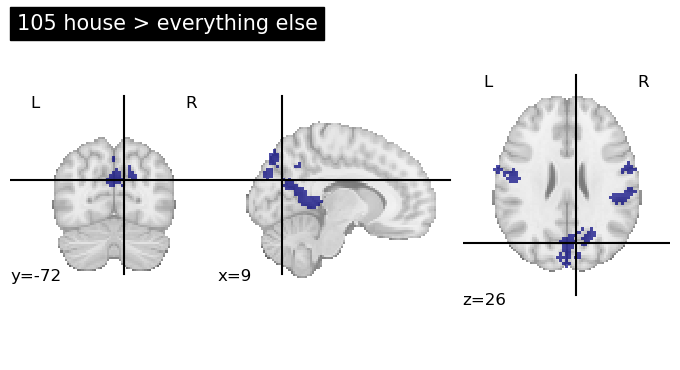

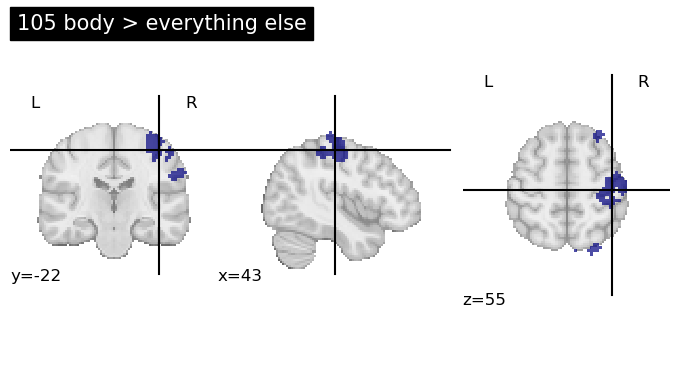

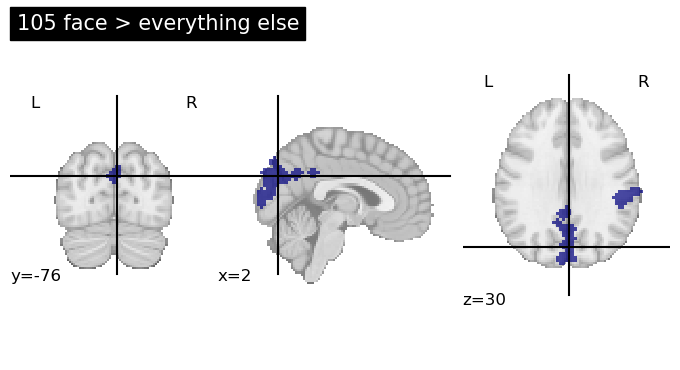

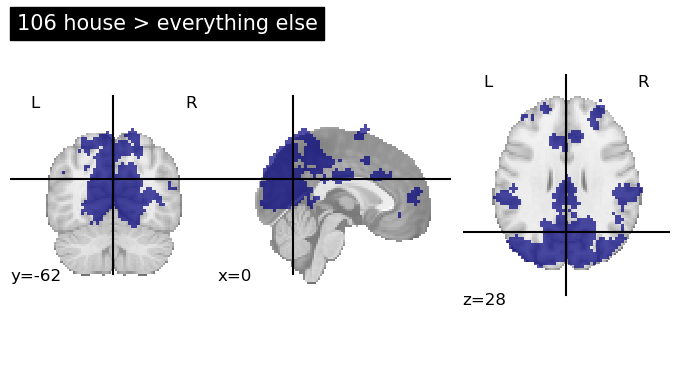

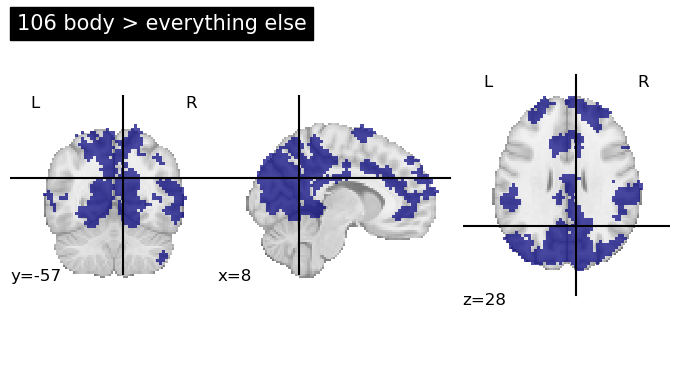

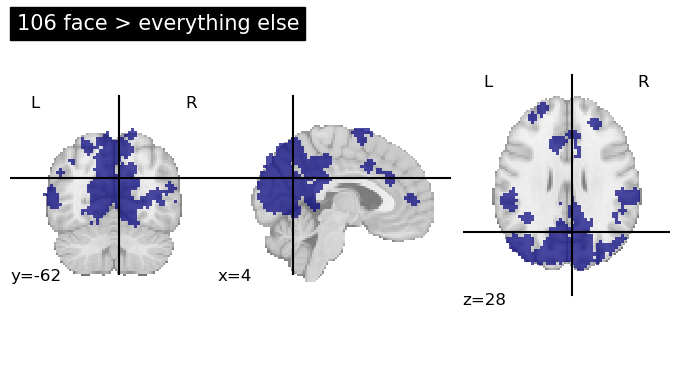

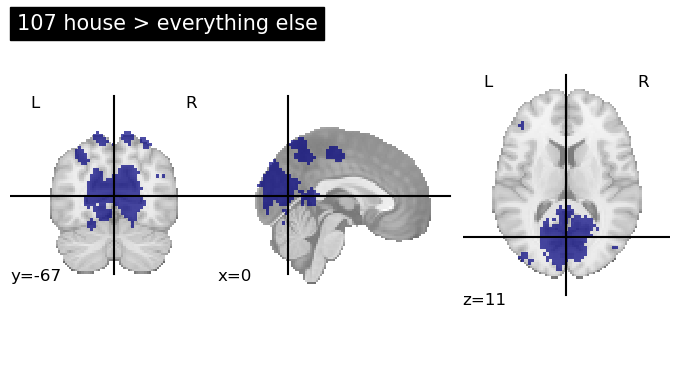

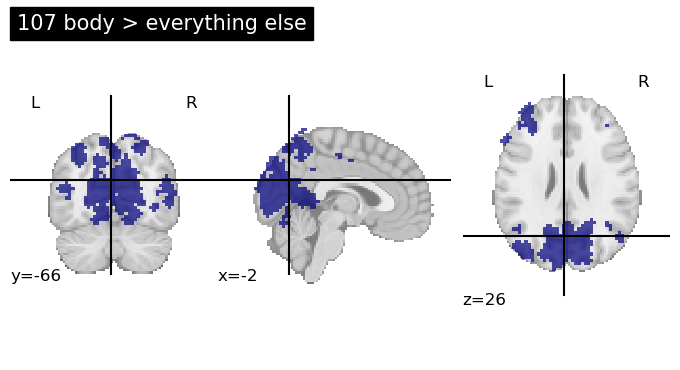

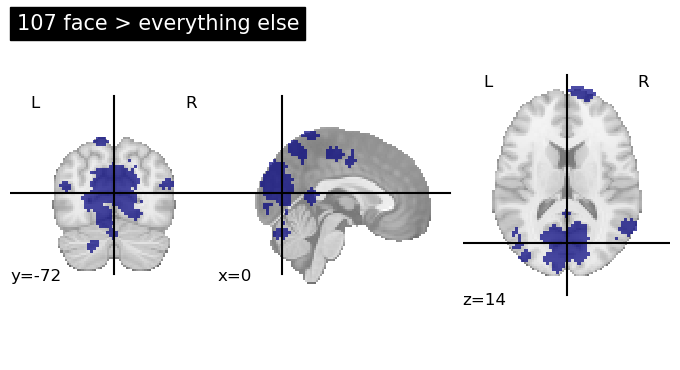

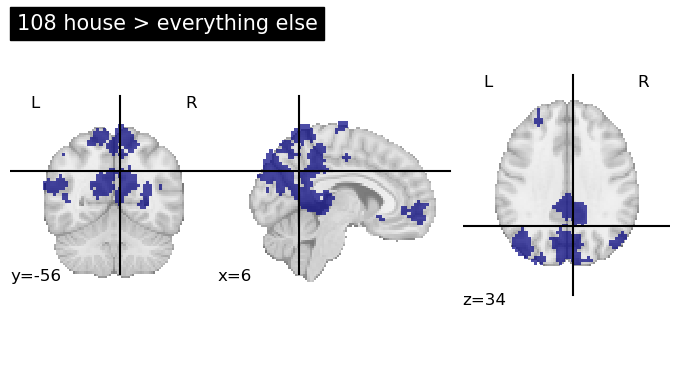

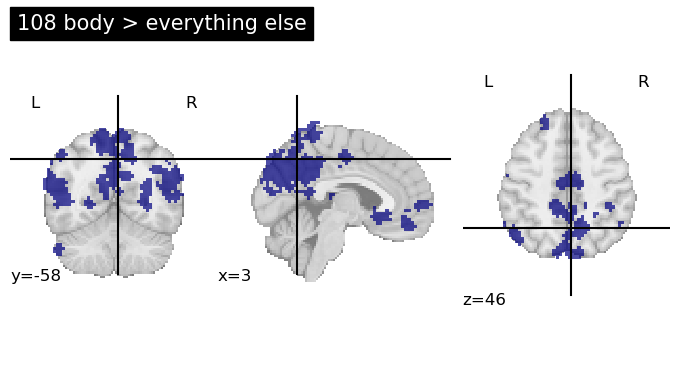

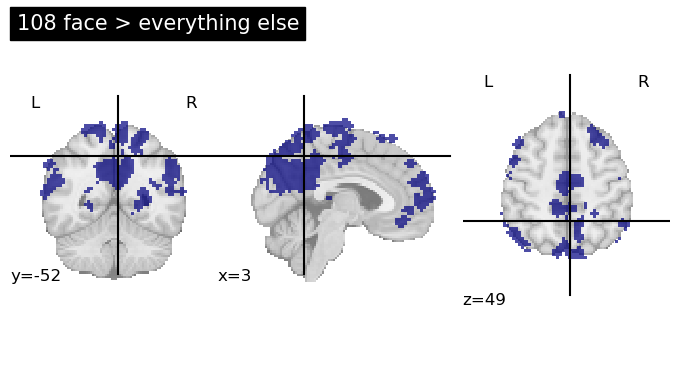

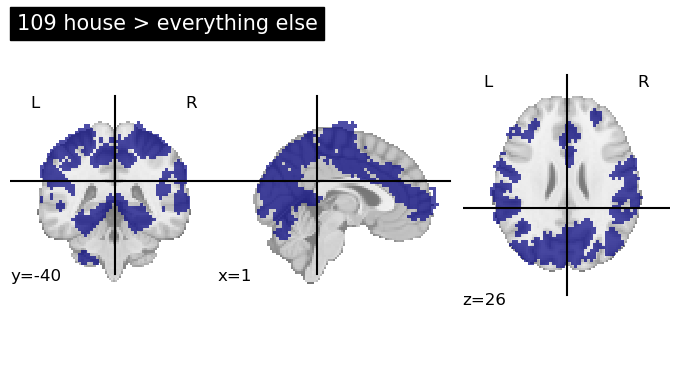

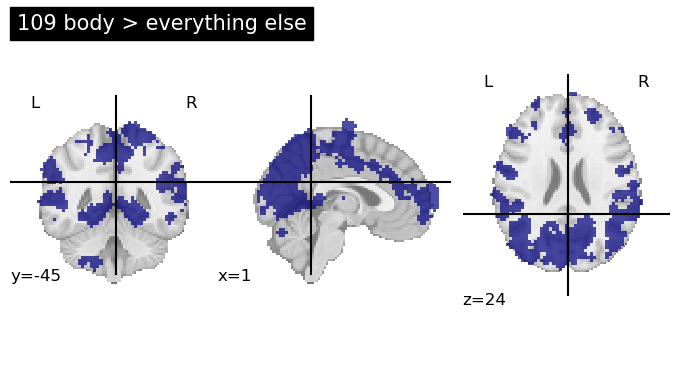

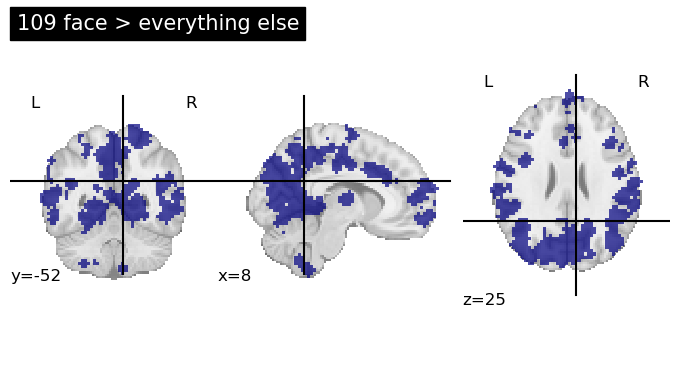

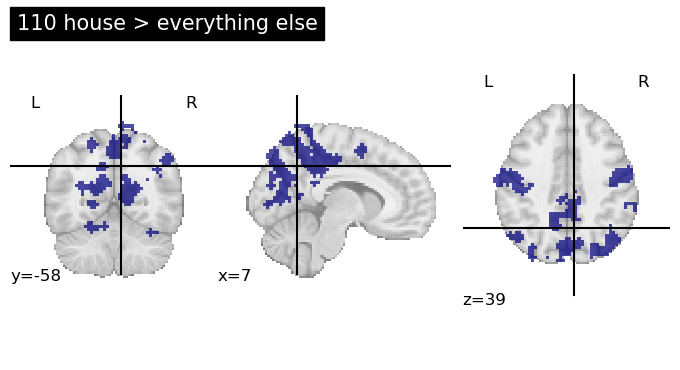

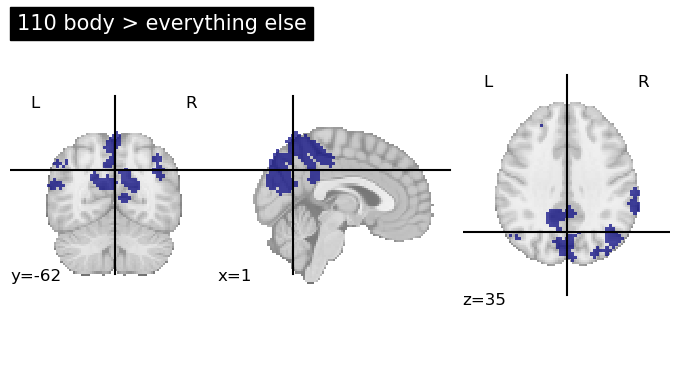

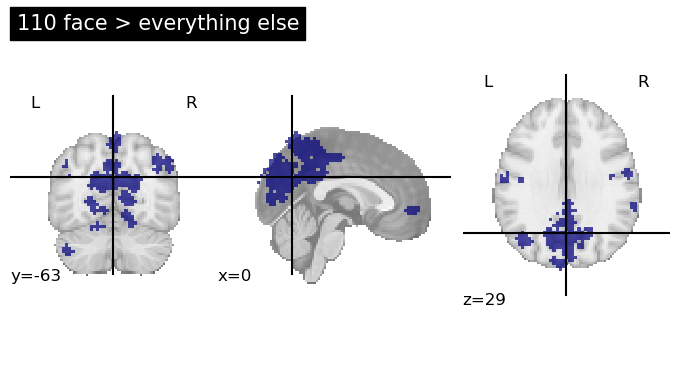

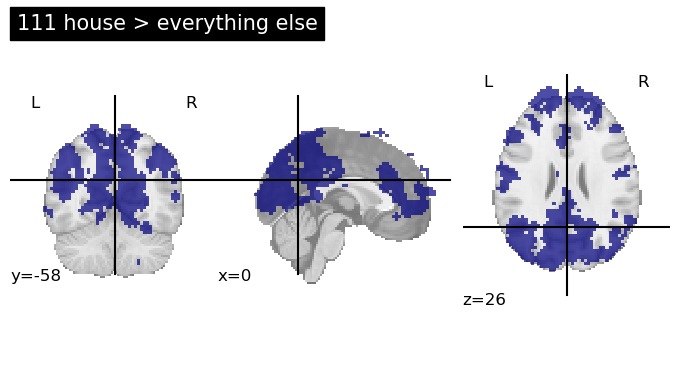

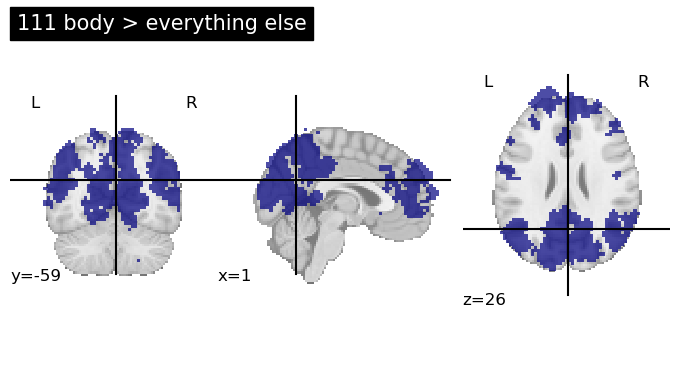

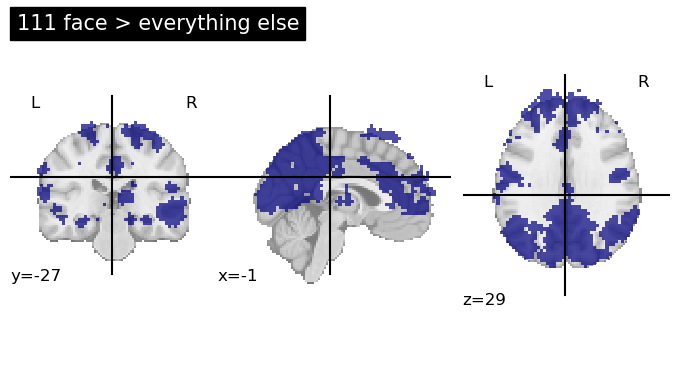

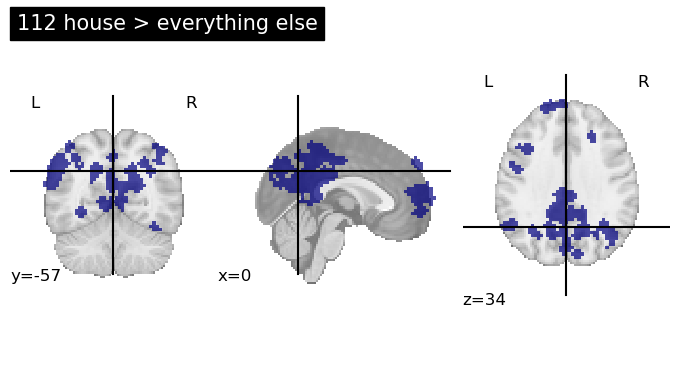

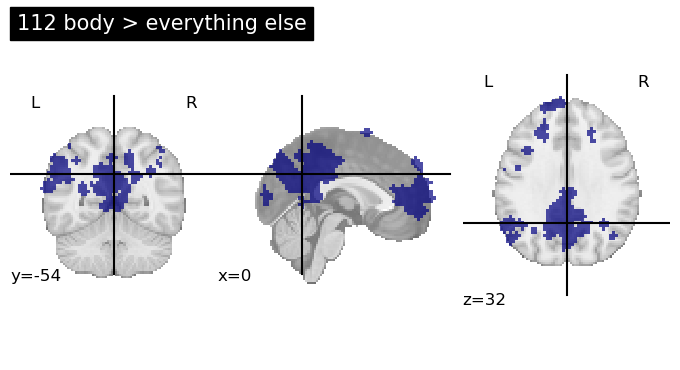

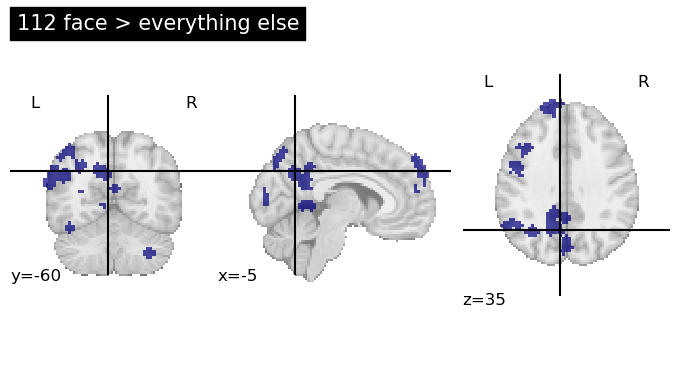

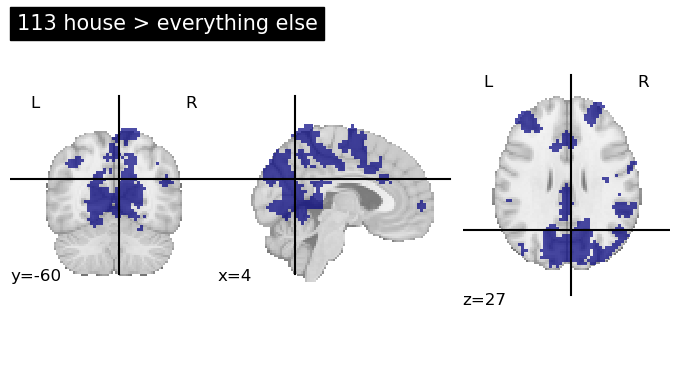

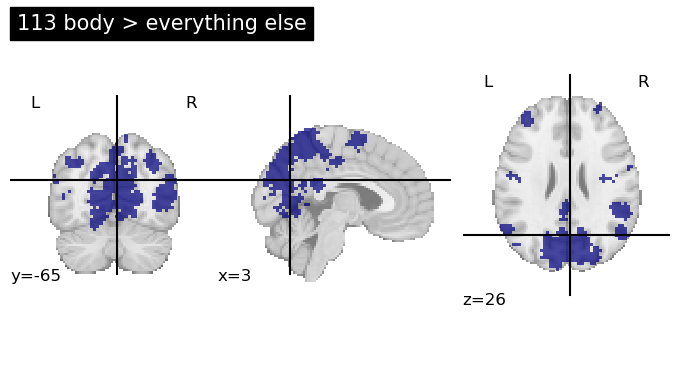

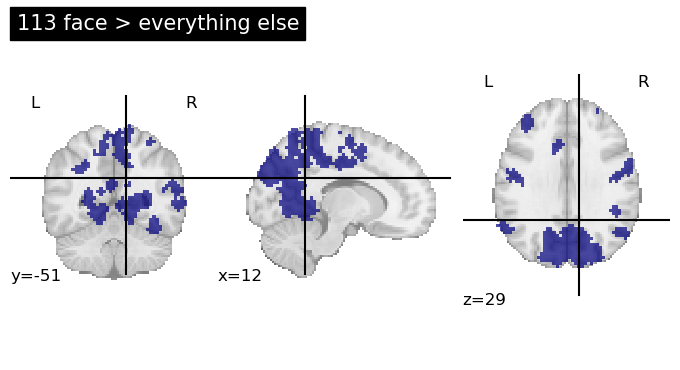

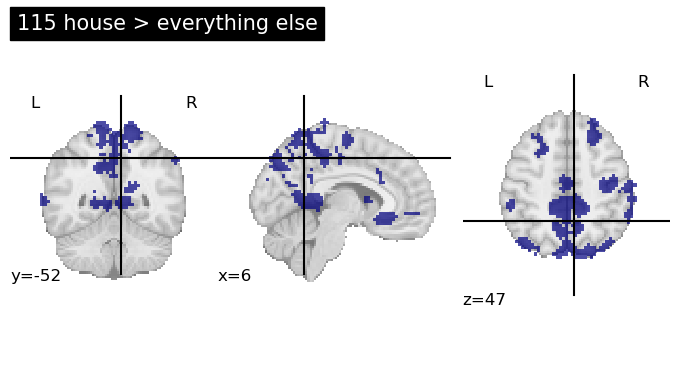

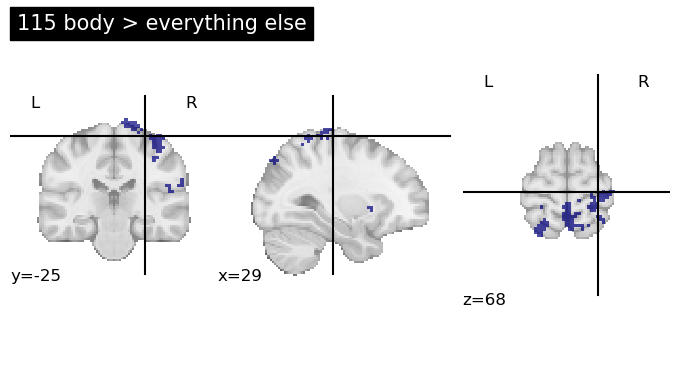

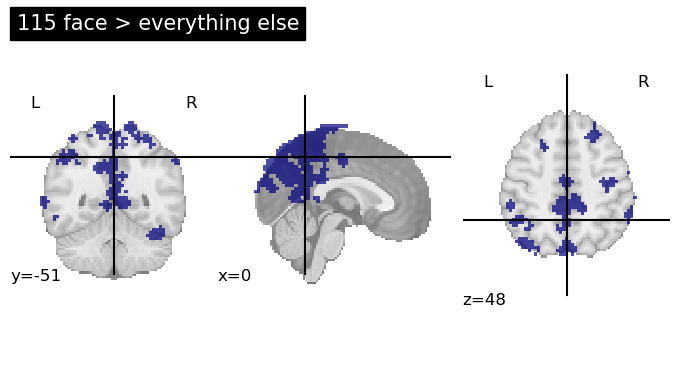

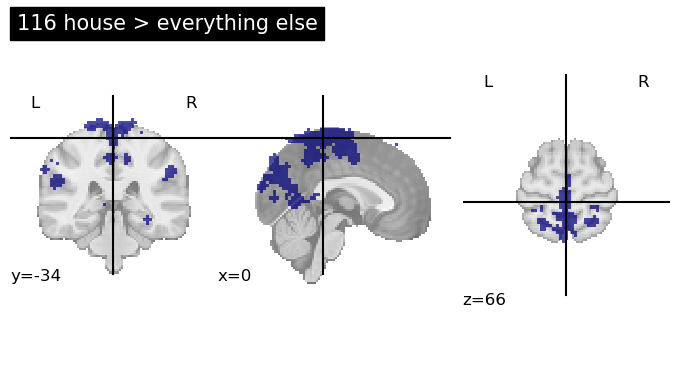

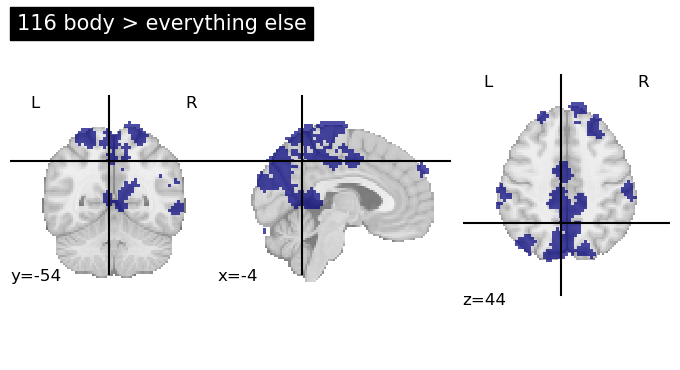

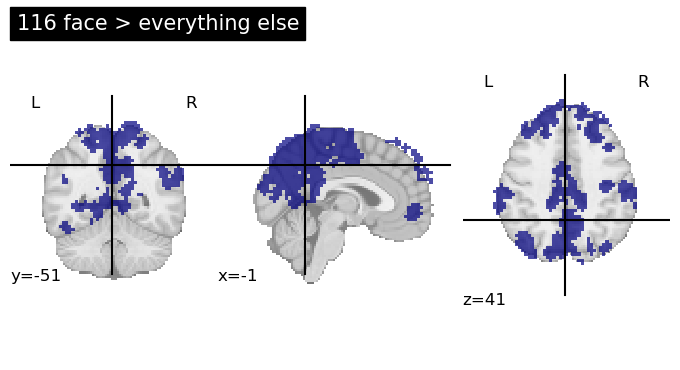

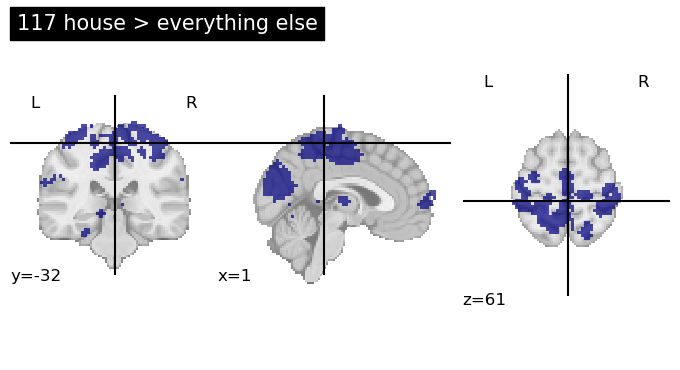

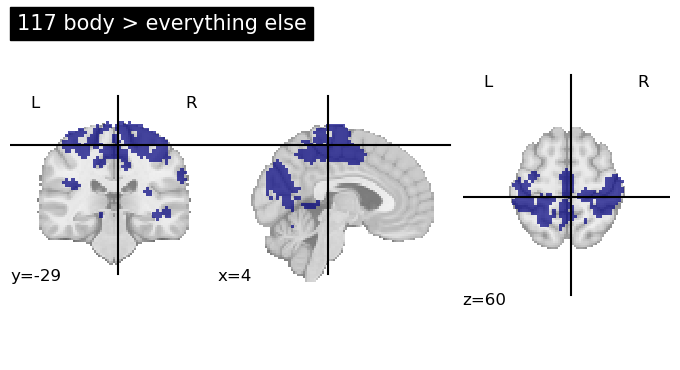

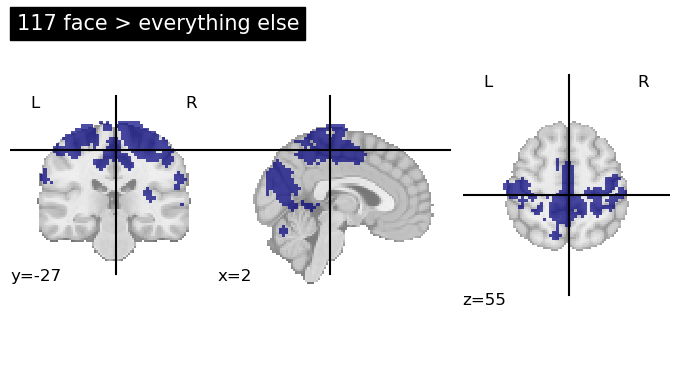

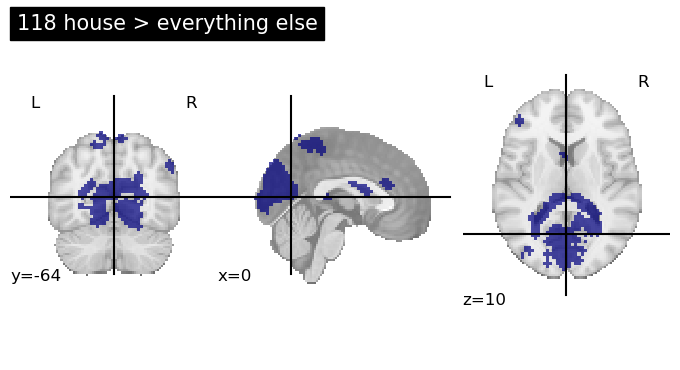

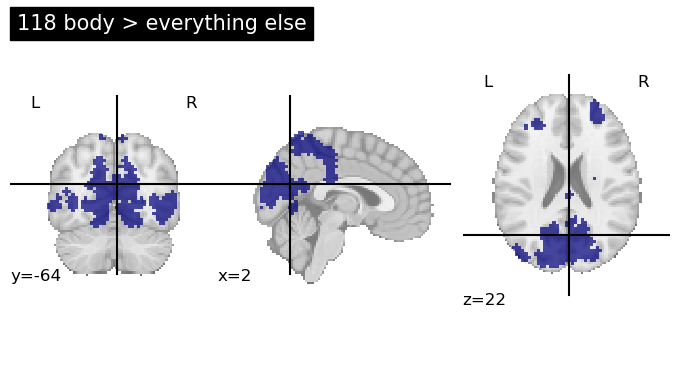

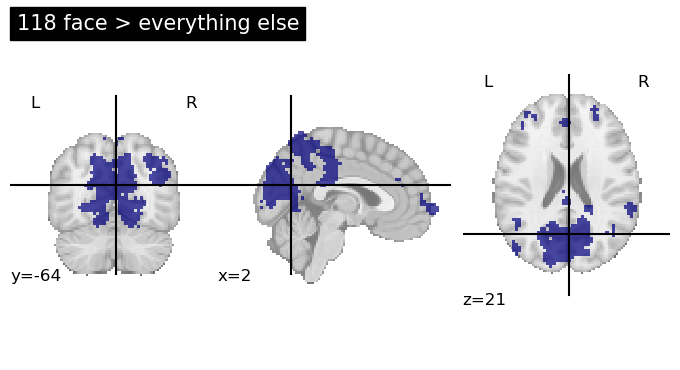

In [60]:
from nilearn.glm import threshold_stats_img
from nibabel import Nifti1Image
from scipy.ndimage import binary_dilation
from nilearn.plotting import plot_roi, show

for sub in subjects:
    subID ='sub-'+sub
    task = "floc"
    run = 0
    hrf_model = "spm"
    high_pass = 0.01
    design_matrices = []

    onsets = create_loc_events_file(sub)

    confound_files = layout.get(subject=sub,
                datatype='func', task=task,
                desc='confounds',
                extension="tsv",
                return_type='file')

    confound_vars = ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
        'trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
        'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
        'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
        'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
        'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2',
        'csf', 'csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
        'white_matter', 'white_matter_derivative1', 'white_matter_derivative1_power2', 'white_matter_power2']

    events, tr, n_scans = load_bids_events(layout, onsets, sub, task, run)
    frame_times = np.arange(n_scans) * tr

    confound_file = confound_files[0]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[confound_vars]
    confound_df.fillna(0, inplace=True)

    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )

    contrast_matrix = []
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }
    contrasts = {
        "body": (basic_contrasts["body"] - basic_contrasts["adult"] - basic_contrasts["house"] - basic_contrasts["scrambled"]),   
        "face": (basic_contrasts["adult"] - basic_contrasts["body"] - basic_contrasts["house"] - basic_contrasts["scrambled"]),   
        "house": (basic_contrasts["house"] - basic_contrasts["adult"] - basic_contrasts["body"] - basic_contrasts["scrambled"]),   
    }

    func_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='preproc',
                            space='MNI152NLin2009cAsym',
                            extension='nii.gz',
                        return_type='file')

    #print("Fitting GLM ...")
    fmri_glm = FirstLevelModel()
    fmri_glm = fmri_glm.fit(func_files, design_matrices=design_matrix)

    #HOUSE
    z_map = fmri_glm.compute_contrast(contrasts['house'], output_type="z_score")
    clean_map, threshold = threshold_stats_img(z_map, alpha=0.05,height_control='fdr',cluster_threshold=10, two_sided=False)

    #binarize mask 
    data = clean_map.get_fdata()
    binarized_data = (data > 0).astype(bool)
    data = binary_dilation(binarized_data)
    house_mask = Nifti1Image(data, z_map.affine, header=z_map.header)
    plot_roi(house_mask,
        title=f'{sub} house > everything else',
    )

    roi_name = f'/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/{subID}/ses-01/func/house.nii'
    nib.save(house_mask, roi_name)

    #BODY
    z_map = fmri_glm.compute_contrast(contrasts['body'], output_type="z_score")
    clean_map, threshold = threshold_stats_img(z_map, alpha=0.05,height_control='fdr',cluster_threshold=10, two_sided=False)

    #binarize mask 
    data = clean_map.get_fdata()
    binarized_data = (data > 0).astype(bool)
    data = binary_dilation(binarized_data)
    body_mask = Nifti1Image(data, z_map.affine, header=z_map.header)
    plot_roi(body_mask,
        title=f'{sub} body > everything else',
    )

    roi_name = f'/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/{subID}/ses-01/func/body.nii'
    nib.save(body_mask, roi_name)

    #FACE
    z_map = fmri_glm.compute_contrast(contrasts['face'], output_type="z_score")
    clean_map, threshold = threshold_stats_img(z_map, alpha=0.05,height_control='fdr',cluster_threshold=10, two_sided=False)

    #binarize mask 
    data = clean_map.get_fdata()
    binarized_data = (data > 0).astype(bool)
    data = binary_dilation(binarized_data)
    face_mask = Nifti1Image(data, z_map.affine, header=z_map.header)
    plot_roi(face_mask,
        title=f'{sub} face > everything else',
    )

    roi_name = f'/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/{subID}/ses-01/func/face.nii'
    nib.save(face_mask, roi_name)

## HIGH-LEVEL TASK ANALYSIS

In [78]:
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)
subjects = layout.get_subjects()

def load_bids_events(layout,onsets, subject, task):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[0])
    n_tr = func_file.shape[-1]
    onsets=onsets
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [1,4,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans


def create_high_events_file(file_path):
    data = pd.read_csv(file_path)  # Adjust delimiter if necessary

    
    # Extract unique blocks
    block_summary = data.groupby("Block").agg({
        "Stimulus Onset (s)": "first",
        "Stimulus Offset (s)": "last",
        "Condition": "first"
    }).reset_index()

    # Rename columns for clarity
    block_summary.rename(columns={
        "Stimulus Onset (s)": "onset",
        "Stimulus Offset (s)": "block_end",
        "Condition": "trial_type"
    }, inplace=True)
    
    block_summary["duration"] = block_summary["block_end"]-block_summary["onset"]
    block_summary["onset"] = np.round(block_summary["onset"])
    block_summary["duration"] = np.round(block_summary["duration"])

    return block_summary



BIDS Layout: ...ktop Drive/AVP-BDD/derivatives | Subjects: 3 | Sessions: 3 | Runs: 9


P001 Faces (run 01)

In [14]:
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker

run_order = ['face','body','house']
# for typical ROI analysis -- will assign 1 value to the V1/V2 ROI extracted above 
# First, initialize masker 
masker = NiftiLabelsMasker(
    face_mask
)

# for small volume cluster correction -- allows values to vary within predefined ROI mask 
# masker = NiftiMasker(
#     maps_img = vis_mask_dil,
# )

In [17]:
onsets = []
run = '1'
cat = 'Face'
file_path = f"/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/sub-{sub}/ses-01/func/Subject_{sub}_Run_{run}_{cat}_RT.csv"
onsets = create_high_events_file(file_path)

In [41]:
sub = subjects[0]
task = 'SFhigh'
run = '01'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,run=run,
              desc='preproc',
              space='MNI152NLin2009cAsym',
              extension='nii.gz',
              return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

time_series = []
for con_img in fmri_imgs:
    time_series.append(masker.fit_transform(con_img))
time_series = np.concatenate(time_series, axis = 0)
len(time_series)

335

In [65]:

confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []

events,tr,n_scans = load_bids_events(layout,onsets, sub, task)
# Define the sampling times for the design matrix
frame_times = np.arange(n_scans) * tr
confound_file = confound_files[0]
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_df = confound_df[final_confounds]
confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model=hrf_model,
    drift_model="polynomial",
    drift_order=3,
    add_regs=confound_df,
    add_reg_names=confound_vars,
    high_pass=high_pass,
)

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"LSF": (basic_contrasts["LSF"] + basic_contrasts["NSF"]),
"HSF": (basic_contrasts["HSF"] - basic_contrasts["NSF"])          
}   

labels, estimates = run_glm(time_series, design_matrix)
contrast_val = [1]
contrast_up = compute_contrast(labels, estimates, contrast_val)

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/contrasts.py:108: UserWarning: t contrasts should be of length P=39, but it has length 1. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


TypeError: only size-1 arrays can be converted to Python scalars

In [67]:
sub = subjects[1]
task = 'SFhigh'
run = '01'

fmri_imgs = layout.get(subject=sub,
              datatype='func', task=task,run=run,
              desc='preproc',
              space='MNI152NLin2009cAsym',
              extension='nii.gz',
              return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

time_series = []
for con_img in fmri_imgs:
    time_series.append(masker.fit_transform(con_img))
time_series = np.concatenate(time_series, axis = 0)


confound_files = layout.get(subject=sub,
                  datatype='func', task=task,
                  desc='confounds',
                  extension="tsv",
                  return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
  #32 confound_vars -- REMOVING GLOBAL SIGNAL 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                      'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                        'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                        'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                        'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                        'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                        'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                        'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                      ]

final_confounds = confound_vars

design_matrices = []

events,tr,n_scans = load_bids_events(layout,onsets, sub, task)
# Define the sampling times for the design matrix
frame_times = np.arange(n_scans) * tr
confound_file = confound_files[0]
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_df = confound_df[final_confounds]
confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model=hrf_model,
    drift_model="polynomial",
    drift_order=3,
    add_regs=confound_df,
    add_reg_names=confound_vars,
    high_pass=high_pass,
)
    

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
column: contrast_matrix[i]
for i, column in enumerate(design_matrix.columns)
}

contrasts = {
"LSF": (basic_contrasts["LSF"] - basic_contrasts["NSF"]),
"HSF": (basic_contrasts["HSF"] - basic_contrasts["NSF"])          
}

labels, estimates = run_glm(time_series, design_matrix)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast_up = compute_contrast(labels=labels, regression_result=estimates, con_val=contrast_val)        
    # z_score = contrast.z_score()
    # effect_size = contrast.effect_size()
    # print(f"{contrast_id}: Z-score outputs: {z_score}") 
    # print(f"{contrast_id}: Beta outputs: {effect_size}")
        

/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


TypeError: only size-1 arrays can be converted to Python scalars

In [39]:
contrast_val

array([ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [125]:
labels, estimates = run_glm(time_series, design_matrix)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val)        

335

In [132]:
labels, estimates = run_glm(time_series, design_matrix)
contrast = compute_contrast(labels, estimates, contrast_val)

TypeError: only size-1 arrays can be converted to Python scalars

In [108]:

events,tr,n_scans = load_bids_events(layout,onsets, sub, task)
# Define the sampling times for the design matrix
frame_times = np.arange(n_scans) * tr
confound_file = confound_files[run]
confound_df = pd.read_csv(confound_file, delimiter='\t')
confound_df = confound_df[final_confounds]
confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model=hrf_model,
    drift_model="polynomial",
    drift_order=3,
    add_regs=confound_df,
    add_reg_names=confound_vars,
    high_pass=high_pass,
)
    

['/Volumes/Seagate Desktop Drive/AVP-BDD/derivatives/sub-P001/ses-01/func/sub-P001_ses-01_task-SFhigh_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

In [110]:
onsets

,block,onset,block_end,trial_type,duration
0,1,10,24,body,14
1,2,28,42,house,14
2,3,46,60,adult,14
3,4,64,78,scrambled,14
4,5,82,96,house,14
5,6,100,114,scrambled,14
6,7,118,132,adult,14
7,8,136,150,body,14
8,9,154,168,house,14
9,10,172,186,body,14
